In [1]:
from __future__ import division, print_function

In [2]:
import os
import sys

import json
import datetime

sys.path.insert(0,'/home/rapplegate/ds_notebooks/share_lib/')

import hyper_context as context
import pyspark
from pyspark.sql.types import Row

hdfs = context.hdfs_system

In [3]:
import pyspark.sql.functions as F

In [4]:
#sc.stop()

In [4]:
sc = context.load_spark_context('RSDS Parquet', 11915, csv_support=True, num_cores=16, memory='12gb')
sqlContext = pyspark.SQLContext(sc)

In [5]:
data_src = os.path.join(hdfs, 'user/rapplegate/to_parquet/2015/08/')

In [6]:
data = sqlContext.read.parquet(data_src)

In [7]:
data.count()

3225331

In [8]:
data.schema

StructType(List(StructField(page_type,StringType,true),StructField(timestamp,LongType,true),StructField(total_cents,LongType,true),StructField(user_token,StringType,true)))

In [25]:
def data_row(row):
    
    date_time = datetime.datetime.fromtimestamp(row.timestamp / 1000.0)
    date = date_time.date()
    hour = date_time.hour
    dollars = row.total_cents / 100.0
    
    return Row(DATE=date, HOUR=hour, DOLLARS=dollars)

In [26]:
f_transformed = data.map(data_row).toDF()

In [ ]:
f_transformed.first()

In [27]:
f_grouped = f_transformed\
    .groupBy('DATE')\
    .agg(
        F.count('DOLLARS').alias('COUNT_ORDERS'),
        F.sum('DOLLARS').alias('SUM_DOLLARS')
    )

In [28]:
f_collected_date = f_grouped.map(lambda r: (r.DATE, r.COUNT_ORDERS, r.SUM_DOLLARS)).collect()

In [29]:
f_collected_date

[(datetime.date(2015, 7, 31), 9671, 1607277.5800000003),
 (datetime.date(2015, 8, 1), 20832, 3329044.35),
 (datetime.date(2015, 8, 2), 15922, 4672600.380000001),
 (datetime.date(2015, 8, 3), 128070, 26773472.960000005),
 (datetime.date(2015, 8, 4), 155611, 32720995.490000013),
 (datetime.date(2015, 8, 5), 154899, 31680061.45),
 (datetime.date(2015, 8, 6), 143983, 29476258.279999997),
 (datetime.date(2015, 8, 7), 113958, 23699540.700000007),
 (datetime.date(2015, 8, 8), 27319, 43351965.32000003),
 (datetime.date(2015, 8, 9), 21299, 3609782.1300000013),
 (datetime.date(2015, 8, 10), 138379, 27406373.290000007),
 (datetime.date(2015, 8, 11), 153786, 30763211.24000002),
 (datetime.date(2015, 8, 12), 148243, 30028538.300000027),
 (datetime.date(2015, 8, 13), 140942, 28364786.980000023),
 (datetime.date(2015, 8, 14), 115226, 23317813.79000001),
 (datetime.date(2015, 8, 15), 24433, 3815078.2800000017),
 (datetime.date(2015, 8, 16), 23121, 4150885.13),
 (datetime.date(2015, 8, 17), 141863, 280

In [9]:
# RSDS
rsds_src = os.path.join(hdfs, 'rs-ds/parquet/2015/08/*')
rsds_src

'hdfs://10.1.10.180/rs-ds/parquet/2015/08/*'

In [10]:
rsds = sqlContext.read.parquet(rsds_src)

In [11]:
rsds.schema

StructType(List(StructField(email,StringType,true),StructField(session_id,StringType,true),StructField(merchant_id,StringType,true),StructField(site_cid,StringType,true),StructField(treatment,StringType,true),StructField(page_type,StringType,true),StructField(order_id,StringType,true),StructField(timestamp,StringType,true),StructField(event_type,StringType,true),StructField(sku,StringType,true),StructField(name,StringType,true),StructField(quantity,StringType,true),StructField(price_cents,StringType,true)))

In [12]:
rsds.count()

485854188

In [13]:
rsds.first()

Row(email=u'famouim@gmail.com', session_id=u'8fc9639f-5e04-4a76-8b4f-e716384b78c9_1438446493009', merchant_id=u'a418e208-fe80-3827-ae20-0e498db95eed', site_cid=u'fea6e45a-b7f6-4264-9512-dda569c0d689', treatment=u'denied', page_type=u'CLASS', order_id=u'', timestamp=u'2015-08-01 16:48:59.042', event_type=u'view', sku=u'371780', name=u'Hilroy ? Journal mode carr? ? motif g?om?trique, 6 3/4 po x 6 3/4 po, 208 pages', quantity=u'1', price_cents=u'97')

In [14]:
def rsds_row(row):
    
    tmp = row.timestamp.split('.')[0]
    dt = datetime.datetime.strptime(tmp, '%Y-%m-%d %H:%M:%S')
    #date_time = datetime.datetime.strptime(row.timestamp, '%Y-%m-%d %H:%M:%S.%f')
    date = dt.date()
    hour = dt.hour
    order_id = row.order_id
    try:
        quantity = int(row.quantity)
    except:
        return None
    
    try:
        dollars = float(row.price_cents) / 100.0
    except:
        return None

    return Row(DATE=date, ORDER_ID=order_id, DOLLARS=dollars*quantity)

In [15]:
rs_transformed = rsds\
    .filter(rsds['event_type'] == 'purchase')\
    .map(rsds_row)\
    .filter(lambda x: x is not None)\
    .toDF()

In [16]:
# debugging weird values in 'quantity' and 'price_cents' fields
rs_transformed.count()

8593270

In [17]:
rs_order_grouped = rs_transformed\
    .groupBy('ORDER_ID')\
    .agg(
        F.count('DOLLARS').alias('COUNT_ITEMS_IN_ORDER'),
        F.min('DATE').alias('START_DATE'),
        F.max('DATE').alias('END_DATE'),
        F.sum('DOLLARS').alias('TOTAL_DOLLARS_IN_ORDER')
    )

In [32]:
rs_order_grouped.count()

2598905

In [33]:
2598905 / 3225331

0.8057793138130629

In [21]:
rs_order_grouped.first()

Row(ORDER_ID=u'9726886754', COUNT_ITEMS_IN_ORDER=1, START_DATE=datetime.date(2015, 8, 8), END_DATE=datetime.date(2015, 8, 8), TOTAL_DOLLARS_IN_ORDER=29.950000000000003)

In [23]:
order_method = rs_order_grouped\
    .groupBy('START_DATE')\
    .agg(
        F.sum('TOTAL_DOLLARS_IN_ORDER').alias('ALL_DOLLARS'),
        F.count('ORDER_ID').alias('count_orders'),
        F.countDistinct('ORDER_ID').alias('count_dis_orders')
    )

In [24]:
order_collected = order_method.map(lambda r: (r[0], r[1], r[2], r[3])).collect()

In [25]:
rs_grouped = rs_transformed\
    .groupBy('DATE')\
    .agg(
        F.countDistinct('ORDER_ID').alias('COUNT_ORDERS'),
        F.count('ORDER_ID').alias('COUNT_PRODUCTS'),
        F.sum('DOLLARS').alias('SUM_DOLLARS')
    )

In [26]:
rs_collected_date = rs_grouped.map(lambda r: (r.DATE, r.COUNT_ORDERS, r.SUM_DOLLARS)).collect()

In [27]:
zip(rs_collected_date, order_collected)

[((datetime.date(2015, 8, 1), 10537, 1452633.9600000083),
  (datetime.datetime(2015, 8, 1, 0, 0), 1452633.9599999993, 10537, 10537)),
 ((datetime.date(2015, 8, 2), 7334, 1064942.9300000074),
  (datetime.datetime(2015, 8, 2, 0, 0), 1064942.9299999995, 7334, 7334)),
 ((datetime.date(2015, 8, 3), 72406, 11027106.62999894),
  (datetime.datetime(2015, 8, 3, 0, 0), 11027214.819999998, 72406, 72406)),
 ((datetime.date(2015, 8, 4), 128394, 20008069.789997913),
  (datetime.datetime(2015, 8, 4, 0, 0), 20008069.790000018, 128394, 128394)),
 ((datetime.date(2015, 8, 5), 127958, 20054457.459997945),
  (datetime.datetime(2015, 8, 5, 0, 0), 20054457.460000012, 127958, 127958)),
 ((datetime.date(2015, 8, 6), 120097, 18875878.129998084),
  (datetime.datetime(2015, 8, 6, 0, 0), 18875769.940000024, 120096, 120096)),
 ((datetime.date(2015, 8, 7), 94471, 14906131.479998238),
  (datetime.datetime(2015, 8, 7, 0, 0), 14906131.480000004, 94471, 94471)),
 ((datetime.date(2015, 8, 8), 17267, 2603207.8699999694),

In [31]:
outf = '/home/rapplegate/data/rsds_data_validate/rsds_order_counts.txt'
with open(outf, 'wb') as fobj:
    x = map(lambda x: datetime.datetime.strftime(x[0], '%Y-%m-%d'), rs_collected_date)
    y = map(lambda x: str(x[1]), rs_collected_date)
    fobj.write( '\n'.join( w + '\t' + v for w, v in zip(x,y)))

In [57]:
xf = []
y1f = []
y2f = []
for point in f_collected_date:
    date = point[0]
    xf.append(date)
    y1f.append(int(point[1]))
    y2f.append(float(point[2]))

In [58]:
xr = []
y1r = []
y2r = []
for point in rs_collected_date:
    date = point[0]
    xr.append(date)
    y1r.append(int(point[1]))
    y2r.append(float(point[2]))

In [59]:
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


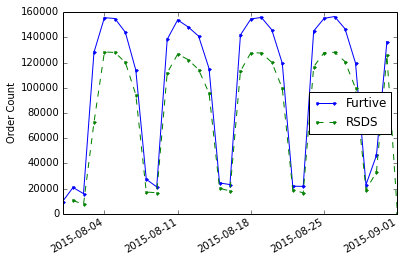

In [60]:
fig, ax = plt.subplots()
fig.autofmt_xdate()

#ax.set_xlim([datetime.date(2015, 8, 1), datetime.date(2015, 9, 1)])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.plot(xf, y1f, 'b.-', label='data')
ax.plot(xr, y1r, 'g.--', label='RSDS')
ax.set_ylabel('Order Count')
ax.legend(loc='best')

fig.savefig('pdfs/data_rsds_2015-08-orders_.pdf')

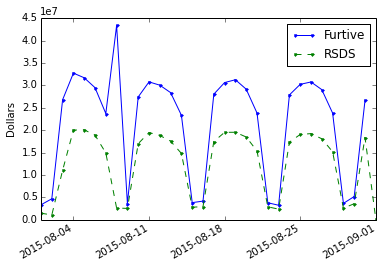

In [61]:
fig, ax = plt.subplots()
fig.autofmt_xdate()

ax.set_xlim([datetime.date(2015, 8, 1), datetime.date(2015, 9, 1)])
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.plot(xf, y2f, 'b.-', label='data')
ax.plot(xr, y2r, 'g.--', label='RSDS')
ax.set_ylabel('Dollars')
ax.legend(loc='best')
fig.savefig('pdfs/data_rsds_2015-08_dollars_.pdf')

In [ ]:
f_collected

In [ ]:
rs_collected

In [ ]:
fig, ax = plt.subplots()
#fig.autofmt_xdate()

ax.set_xlim([0, 24])
#fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#fig.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.plot(xf, y1f, 'b.-', label='data')
ax.plot(xr, y1r, 'g.--', label='RSDS')
ax.set_ylabel('Order Count')
ax.legend(loc='best')

fig.savefig('pdfs/data_rsds_2015-09-orders_hourly.pdf')

In [ ]:
fig, ax = plt.subplots()
#fig.autofmt_xdate()

ax.set_xlim([0, 24])
#fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#fig.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.plot(xf, y2f, 'b.-', label='data')
ax.plot(xr, y2r, 'g.--', label='RSDS')
ax.set_ylabel('Order Count')
ax.legend(loc='best')

fig.savefig('pdfs/data_rsds_2015-09-orders_hourly.pdf')